In [280]:
# data manipulation modules
import json
import pandas as pd
import numpy as np
from datetime import datetime

# visualisations modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

# feature selection modules
from sklearn.feature_selection import chi2, f_classif

#ML modules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree

### Part 1: Exploratory data analysis

In [42]:
logins = pd.read_json('logins.json').set_index('login_time')
logins['no. of logins'] = 1

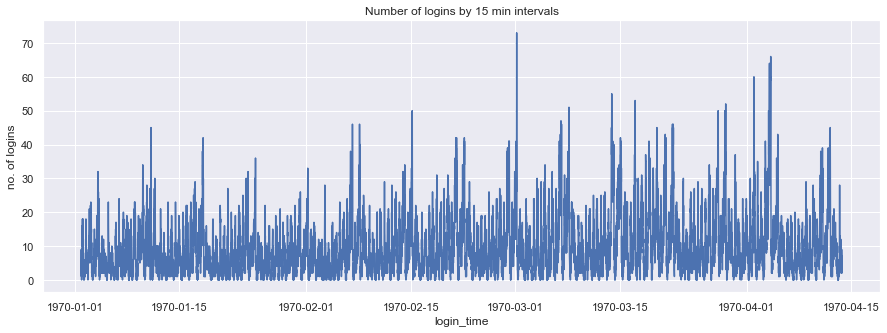

In [110]:
resampled_logins = logins.resample('15T').sum().reset_index()

fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x='login_time', y='no. of logins', data=resampled_logins)
plt.title('Number of logins by 15 min intervals')
plt.show()

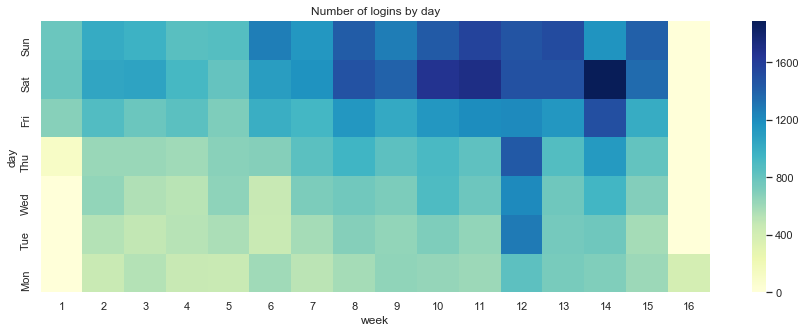

In [124]:
daily_logins = logins.resample('D').sum().reset_index()
daily_logins['week'] = daily_logins.login_time.dt.week
daily_logins['day'] = daily_logins.login_time.dt.weekday

fig, ax = plt.subplots(figsize=(15, 5))
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax = sns.heatmap(daily_logins.pivot('day', 'week', 'no. of logins').fillna(0), yticklabels=day_labels, cmap="YlGnBu")
plt.ylim([0, 7])
plt.title('Number of logins by day')
plt.show()

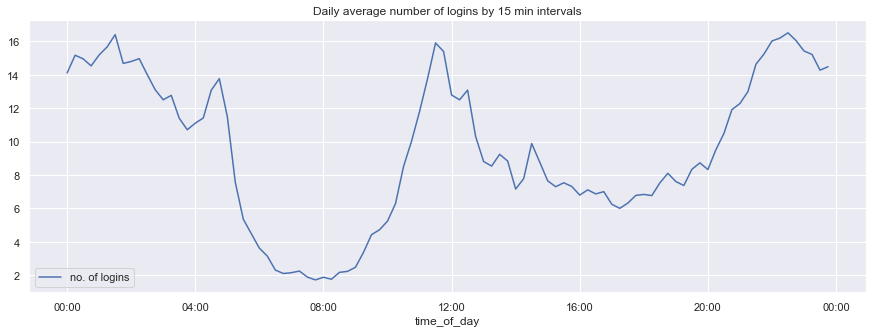

In [184]:
date = str(datetime.strptime('1970-01-01', '%Y-%m-%d').date())
resampled_logins['time_of_day'] = pd.to_datetime(date + " " + resampled_logins.login_time.dt.time.astype(str))

fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(data=resampled_logins.groupby('time_of_day').mean())
ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title('Daily average number of logins by 15 min intervals')
plt.show()

<b>Based on our visulaisations, we can see that on average, logins are high at noon and early morning and very low from 6am to 9am. We can also see that logins are generally higher from Fri-Sun with increasing number of logins during later parts of the time period. There also seems to be an unusually high number of logins during the weekdays of week 12.

### Part 2: Experiment and metrics design

<b>To measure the success of the experiment, we can look at the number of trips each driver partner takes in the other city for a fixed time period. For example, based on the information that drivers tend to be exclusive to the city, we can assume that the initial distribution has a mean close to 0 and very small variance. Given that the main aim of the experiment is to encourage drivers to not be exclusive, this seems to be the best metric to check if drivers are taking trips outside their city.

<b>The impact of the experiment can be emasures by an A/B test. We will first need to choose a time period which should be a factor of weeks to prevent impact of weekly cyclicality. We can then extend the toll payment optionality to half of the drivers selected at random and then measure the metrics for both driver set A (toll payment implemented) and driver set B (nothing has changed). We can then use a KS(Kolmogorov–Smirnov) test to see if the samples from set A is statistically different from samples in set B. If we can show that the p-value of the KS test is less than the level of significance that we define (usually <0.05), then we can show that the results are statistically significant and that the toll payment has a statistically significant impact on our metric. We would then recommend the implementation of the toll payment with the caveat that there is still a possibility of a type 1/2 error or a misleading test due to sample size or sampling window.

### Part 3: Predictive modeling

In [17]:
def json_to_pandas(path):
    with open(path, 'r') as f:
        content = f.read()
    return pd.DataFrame(json.loads(content))

In [41]:
#read file and set date types
user_activity = json_to_pandas('ultimate_data_challenge.json')
date_cols = ['signup_date', 'last_trip_date']
user_activity[date_cols] = user_activity[date_cols].apply(pd.to_datetime)
user_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [42]:
#set target column -> retained?
user_activity['last_trip_days'] = (user_activity.last_trip_date.max() - user_activity.last_trip_date).dt.days 
user_activity['retained'] = (user_activity['last_trip_days'] <= 30).astype(int)
user_activity = user_activity.drop(columns='last_trip_date')

In [80]:
print('{:.2f}% of users are retained'.format(user_activity.retained.sum()/len(user_activity)*100))

37.61% of users are retained


### Data Visualisations

In [66]:
def categorical_hist_plot(x_col, df, category_col, ax):
    for category in df[category_col].unique():
        sns.distplot(df[df[category_col] == category][x_col].dropna(), ax=ax, label=category)
    ax.legend()

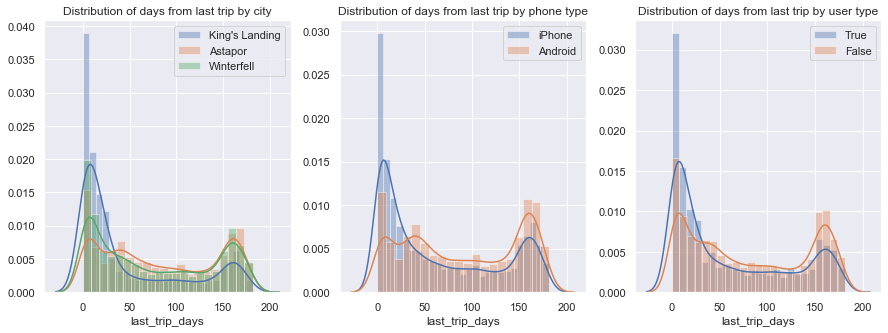

In [98]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
categorical_hist_plot('last_trip_days', user_activity, 'city', ax1)
ax1.set_title('Distribution of days from last trip by city')

categorical_hist_plot('last_trip_days', user_activity, 'phone', ax2)
ax2.set_title('Distribution of days from last trip by phone type')

categorical_hist_plot('last_trip_days', user_activity, 'ultimate_black_user', ax3)
ax3.set_title('Distribution of days from last trip by user type')
plt.show()

<b> Based on these visualisations, we can see that the city, phone type and user type(ultimate balck user) has an impact on when the last trip was taken. For example, users signed up in King's Landing and iPhone users are more likely to have taken a trip more recently and users who took an ultimate black in their first 30 days are also more likely to have taken a trip more recently.

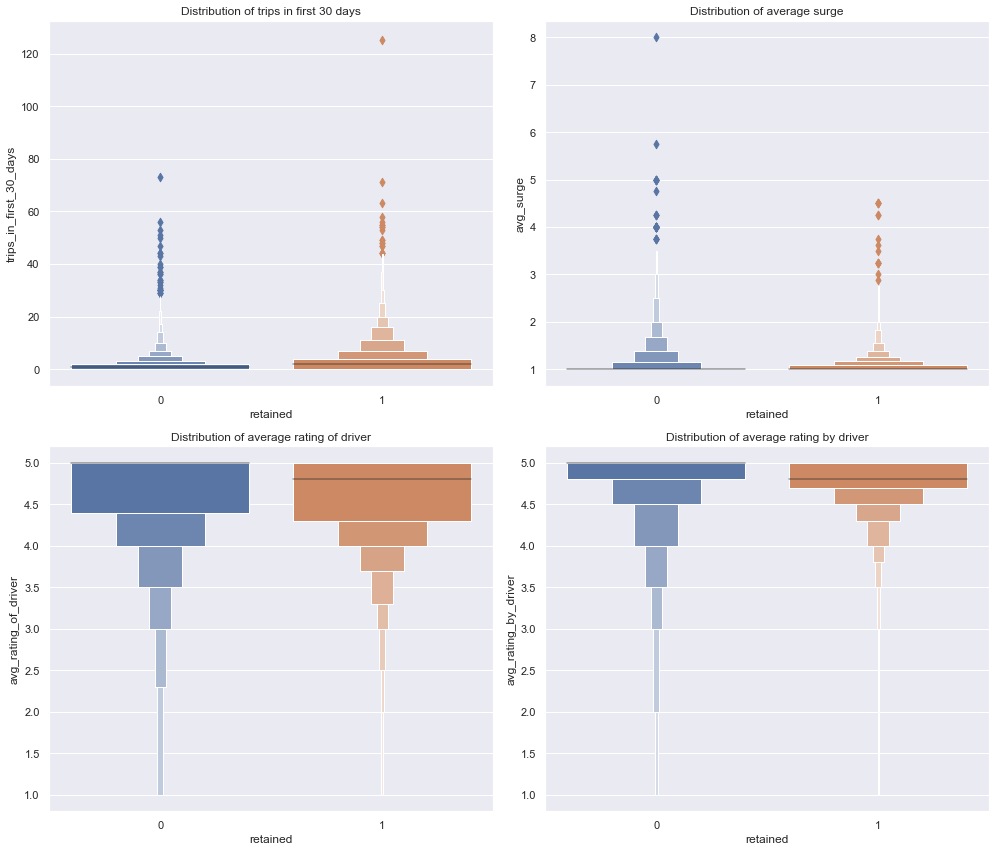

In [165]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(14, 12))
sns.boxenplot(x='retained', y='trips_in_first_30_days', data=user_activity, ax=ax1[0])
ax1[0].set_title('Distribution of trips in first 30 days')

sns.boxenplot(x='retained', y='avg_surge', data=user_activity, ax=ax1[1])
ax1[1].set_title('Distribution of average surge')

sns.boxenplot(x='retained', y='avg_rating_of_driver', data=user_activity, ax=ax2[0])
ax2[0].set_title('Distribution of average rating of driver')

sns.boxenplot(x='retained', y='avg_rating_by_driver', data=user_activity, ax=ax2[1])
ax2[1].set_title('Distribution of average rating by driver')
plt.tight_layout()
plt.show()

<b>We use boxplots here to look at the relationship between the numerical variables and our target category. The boxplot also helps us see extreme values in the dataset. We can see that retained users have taken a higher number of trips in the first 30 days based on the higher median and percentile values. The distribution of ratings generally seems lower for retained users and this might be because retained users might have taken more trips which generally moderates the ratings. The median of the average surge multipler is higher for retained users by non retained users have some very extreme values. This again could be a problem of comparing different number of rides. 

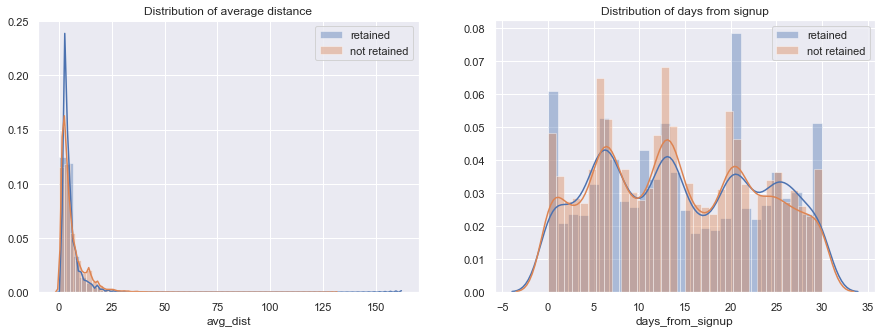

In [160]:
labels = ['retained', 'not retained']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
categorical_hist_plot('avg_dist', user_activity, 'retained', ax1)
ax1.legend(labels)
ax1.set_title('Distribution of average distance')

user_activity['days_from_signup'] = (user_activity.signup_date.max() - user_activity.signup_date).dt.days
categorical_hist_plot('days_from_signup', user_activity, 'retained', ax2)
ax2.legend(labels)
ax2.set_title('Distribution of days from signup')
plt.show()

<b>For average distance and days from signup, we cannot really see a difference based on visualisations. We will have to determine during feature selection if these variables are a good indicator for the target.

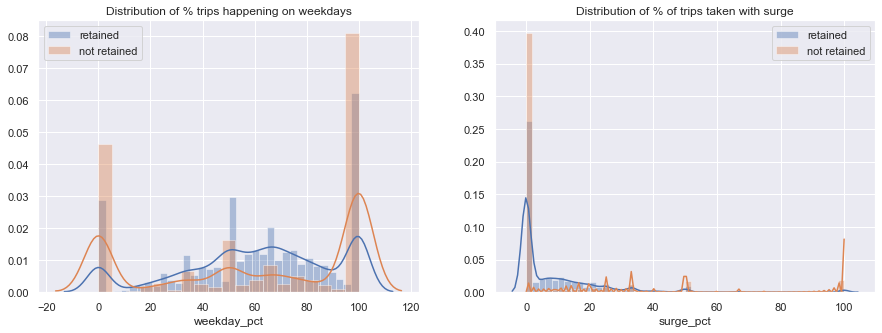

In [163]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
categorical_hist_plot('weekday_pct', user_activity, 'retained', ax1)
ax1.legend(labels)
ax1.set_title('Distribution of % trips happening on weekdays')

categorical_hist_plot('surge_pct', user_activity, 'retained', ax2)
ax2.legend(labels)
ax2.set_title('Distribution of % of trips taken with surge')
plt.show()

<b>Based on these visualisations, we can see that non retained users are highly likely to have all their trips fall on a weekday or have all their trips fall on a weekend. This is again an issue of selection bias where the dataset is probably skewed by the few number of trips taken by the user. We can see a similar patter with the variable surge_pct.

### Data Cleaning

In [235]:
# remove null values and seperate dataset into features and target
X = user_activity.drop(columns=['signup_date', 'retained']).fillna(0)
X.ultimate_black_user = X.ultimate_black_user.astype(int)
y = user_activity.retained
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null int32
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
last_trip_days            50000 non-null int64
days_from_signup          50000 non-null int64
dtypes: float64(6), int32(1), int64(3), object(2)
memory usage: 4.4+ MB


### Feature Selection

<b>First, we will do some feature selection based on statistical tests which can tell us if the relationship between the feature and target is statistically significant enough to consider it. We will use Chi-2 tests for categorical variables and ANOVA tests for numerical variables.

In [238]:
X_cat = X[cat_features]
X_cat = pd.get_dummies(X_cat)

In [239]:
# chi-2 test for categorical features - use confidence interval of 95%
def get_accepted_features(label, arr):
    if label[1] <= .05:
        print(label, 'accepted')
        arr.append(label[0])
    else:
        print(label, 'rejected')
    return arr
    
accepted = []
for label in zip(X_cat.columns, chi2(X_cat, y)[1]):
    accepted = get_accepted_features(label, accepted)

('ultimate_black_user', 1.2918836098370872e-286) accepted
('city_Astapor', 5.252582734355245e-224) accepted
("city_King's Landing", 0.0) accepted
('city_Winterfell', 2.717854482633977e-14) accepted
('phone_0', 0.0984645310383979) rejected
('phone_Android', 0.0) accepted
('phone_iPhone', 3.9375953095305743e-172) accepted


In [240]:
X_num = X[num_features].drop(columns='last_trip_days')
for label in zip(X_num.columns, f_classif(X_num, y)[1]):
    accepted = get_accepted_features(label, accepted)

('trips_in_first_30_days', 0.0) accepted
('avg_rating_of_driver', 1.0945490637182019e-241) accepted
('avg_surge', 0.45609843699455843) rejected
('surge_pct', 0.008343129091397207) accepted
('weekday_pct', 0.030203503149843394) accepted
('avg_dist', 5.270976361581913e-96) accepted
('avg_rating_by_driver', 0.08779464708982121) rejected
('days_from_signup', 6.1962351975837215e-06) accepted


In [253]:
X = pd.get_dummies(X)[accepted]
cat_features = X.columns[:6]
num_features = X.columns[~X.columns.isin(cat_features)]

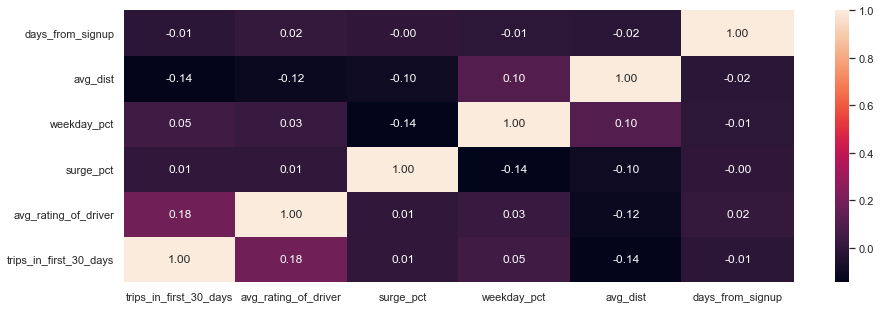

In [255]:
corr = X[num_features].corr()
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, ax=ax, fmt='.2f')
plt.ylim([0, 6])
plt.show()

<b>We can see that none of our numerical features are highly correlated with one another which is good. 

### Modelling

<b>This is a binary clasification problem which a slightly unbalanced dataset. The metrics we choose will depend ultimately on what the most important goal is. For this case, as no specific goal is provided, we will use AOC-ROC for our metric. This measures how good the classfier is at distinguishing the classes. We will try out 2 models: random forest and gradient boosted trees. We choose these models due to their probabilistic interpretation and ability to identify feature importances. We could also choose logistic regression or support vector machines methods but the former might be too simplistic to model the problem and the latter is not interpretable enough (doesn't do feature importances).

In [258]:
def print_metrics(train_actual, train_predicted, actual, predicted, report=True):
    print('Training Accuracy:{}'.format(accuracy_score(train_actual, train_predicted)))
    print('Test Accuracy:{}'.format(accuracy_score(actual, predicted)))
    print('ROC AUC score:{}'.format(roc_auc_score(actual, predicted)))
    print('\n')
    if report:
        print(classification_report(actual, predicted))

    mat = confusion_matrix(actual, predicted)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.ylim([0, 2])
    
def plot_coeffs(X_test, coeffs):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax = plt.barh(X_test.columns, width = coeffs)
    plt.title('Coefficients of features')
    plt.show()

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(35000, 12) (15000, 12)
(35000,) (15000,)


Training Accuracy:0.6231428571428571
Test Accuracy:0.6257333333333334
ROC AUC score:0.5




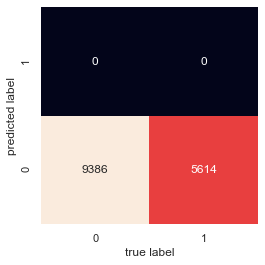

In [286]:
#benchmark model -  assume all not retained users
print_metrics(y_train, np.zeros(len(y_train)), y_test, np.zeros(len(y_test)), report=False)

In [287]:
#random forest classifier
rf = RandomForestClassifier(random_state=0, class_weight='balanced_subsample')
parameters = {'n_estimators':[100, 150, 200], 'max_depth':[5, 10, 20]}
clf_rf = GridSearchCV(rf, parameters, scoring='roc_auc', cv=5)
best_rf = clf_rf.fit(X_train, y_train).best_estimator_

Training Accuracy:0.8050571428571428
Test Accuracy:0.7834666666666666
ROC AUC score:0.7550697622022082


              precision    recall  f1-score   support

           0       0.80      0.87      0.83      9386
           1       0.74      0.64      0.69      5614

    accuracy                           0.78     15000
   macro avg       0.77      0.76      0.76     15000
weighted avg       0.78      0.78      0.78     15000



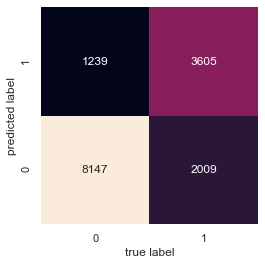

In [275]:
y_pred = best_rf.predict(X_test)
print_metrics(y_train, best_rf.predict(X_train), y_test, y_pred)

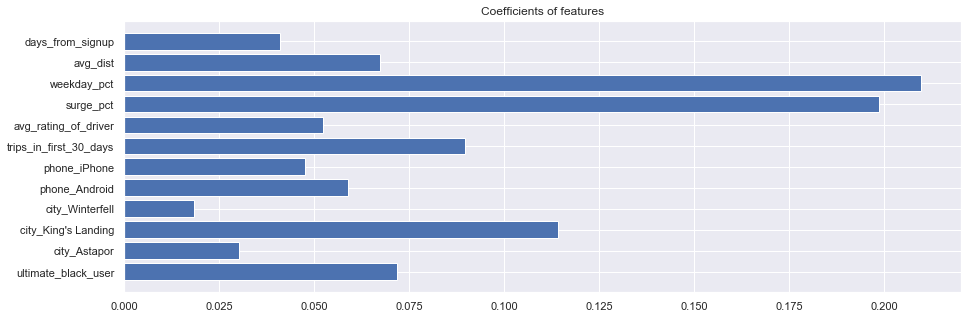

In [278]:
plot_coeffs(X_test, best_rf.feature_importances_)

Training Accuracy:0.8023714285714286
Test Accuracy:0.7870666666666667
ROC AUC score:0.7606665962714899


              precision    recall  f1-score   support

           0       0.81      0.87      0.84      9386
           1       0.74      0.66      0.70      5614

    accuracy                           0.79     15000
   macro avg       0.78      0.76      0.77     15000
weighted avg       0.78      0.79      0.78     15000



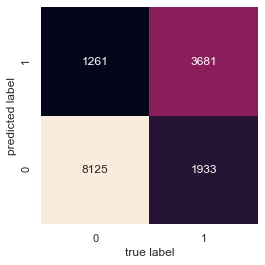

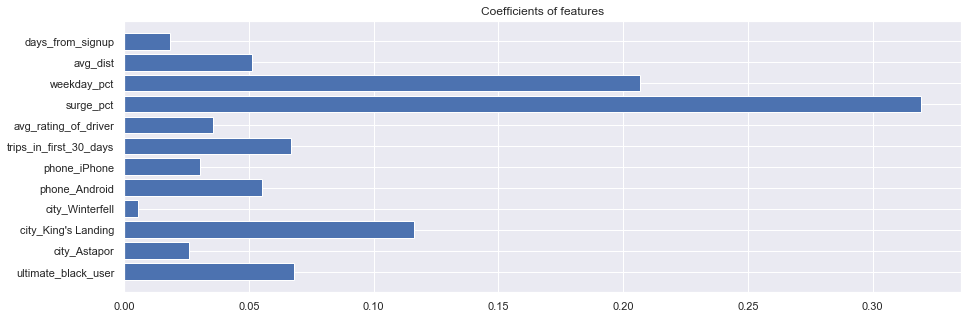

In [282]:
#gradient boosting classfier
gbm = GradientBoostingClassifier(loss='deviance', random_state=0, subsample=0.8)
parameters = {'n_estimators':[50, 70, 100], 'max_depth':[3, 5, 7]}
clf_gbm = GridSearchCV(gbm, parameters, scoring='roc_auc', cv=5)
best_gbm = clf_gbm.fit(X_train, y_train).best_estimator_

y_pred = best_gbm.predict(X_test)
print_metrics(y_train, best_gbm.predict(X_train), y_test, y_pred)
plot_coeffs(X_test, best_gbm.feature_importances_)

<b>We can see that both the random forest classifier and gradient boosting classfier are an improvement on the benchmark model. We can further work on improving the model by tuning the hyperparameters. The gradient boosted classifier seems to perform slightly better than the random forest. Ultimate can use this model to identify unengaged users and implement measures to try an re-engage them. It can then measure the impact of these implementations using an A/B test. 

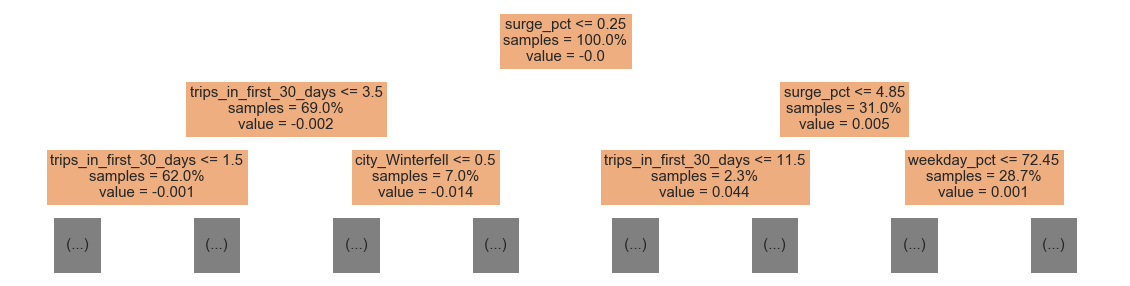

In [336]:
# visualise part of final tree from gbm model
fig, ax = plt.subplots(figsize=(20, 5))
tree.plot_tree(best_gbm.estimators_[-1, 0], filled=True, ax=ax, feature_names=X.columns, impurity=False,
              proportion=True, max_depth=2, fontsize=15)
plt.show()